Etwas Styling ...

In [2]:
%%html
<style>
h1 { color: rgb(226, 0, 26); }
h2 { color: rgb(0, 80, 120); }
.output_png { display: table-cell;  text-align: center;  vertical-align: middle; }
</style>

# BigData - DBWeather
---
*Programmentwurf - Wintersemester 2022 - DHBW Mannheim*\
Daniel Czeschner, Kai Grübener, Frederik Wolter

## 0. Inhalt

1. Business Understanding

2. Data Understanding

3. Data Preperation

4. Modeling

5. Evaluation

6. Deployment

*... in Anlehnung an CRISP-DM*

## 1. Business Understanding

* __Perspektive__: Deutsche Bahn

* __Vermutung__: 

<center><i>Klimaanlagen sorgen für Störungen bei extremen Temperaturen, besonders bei ICE's</i></center>

* __Ziel__: 
  * Erhebung & Auswertung von Daten zu Zugverspätungen & -ausfällen
  * Grundlegende statistische Darstellung von Fahrplan-Änderungs-Daten 
  * Erhebung von Wetterdaten für die Analyse potentieller Korrelationen

## 2. Data Understanding

Verfügbare Datenquellen:
  * Deutsche Bahn _Timetable_ API<br> 
    `apis.deutschebahn.com/db-api-marketplace/apis/timetables/`
  
  * Deutsche Bahn _Reiseauskunft_ API<br>
    `reiseauskunft.bahn.de/bin/`
  
  * _BrightSky_ API<br>
    `api.brightsky.dev/`

## 2.1 Data Understanding – DB Timetable

* API des Deutschen Bahn API-Marketplace

* `/station/{pattern}`
```xml
<station meta="518342" name="Mannheim Hbf" eva="8000244" p="..." ...="" />
```

* `/fchg/{evaNo}`: viele schlecht dokumentiert Daten über Fahrplan-Änderungen
  * Zugtyp, Zugnummer
  * Durchsagen? 
  * **geänderte** Gleise, Halte, Ankünfte, Abfahrten, Ausfälle
    <div class="alert alert-danger">
        <b>Achtung:</b> keine Plan-Daten (andere API) -> ungeignet für Verspätungsbestimmung
    </div>

## 2.2 Data Understanding – DB Reiseauskunft

* API der Deutschen Bahn – _"not so official"_

* `bhftafel.exe/dn?boardType={arr|dep}&input={evaNo}`
  
    <pre><code class="cm-s-ipython language-json" style="max-height: none;">    8000244 Mannheim Hbf
      17:23
      IC  2217
      <span class="cm-string cm-property">+ 35</span>
      17:24
      S      1
      <span class="cm-string cm-property">no</span>
      17:31
      ICE  611
      <span class="cm-string cm-property">cancel</span>
      17:33
      ICE  42
      <span class="cm-string cm-property">+ 5</span></code></pre>

## 2.3 Data Understanding – BrightSky

* API des Deutschen Wetterdienstes

* `/weather?lat={Latitude}&lon={Longitude}&date={Date}`

    <pre><code class="cm-s-ipython language-json" style="max-height: none;">   <span class="cm-string">"weather"</span>: [{ 
                    <span class="cm-string cm-property">"timestamp"</span>: <span class="cm-string">"2022-11-03T00:00:00+01:00"</span>,
                    <span class="cm-string cm-property">"source_id"</span>: <span class="cm-number">184401</span>,
                    <span class="cm-string cm-property">"pressure_msl"</span>: <span class="cm-number">1021.7</span>,
                    <span class="cm-string cm-property">"sunshine"</span>: <span class="cm-number">0.0</span>,
                    <span class="cm-string cm-property">"temperature"</span>: <span class="cm-number">6.8</span>,     
                    <span class="cm-string cm-property">"condition"</span>: <span class="cm-string">"dry"</span>,
                    <span class="cm-string cm-property">"wind_speed"</span>: <span class="cm-number">4.3</span>,
                    <span class="cm-string cm-property">"cloud_cover"</span>: <span class="cm-number">100</span>,     
                    <span class="cm-string cm-property">"relative_humidity"</span>: <span class="cm-number">96</span>, <span class="cm-meta">...</span>
                  }, <span class="cm-meta">...</span> ],</code></pre>
    ```json
    "sources": [ ... ]
    ```

## 3. Data Preparation

__Abspeichern der Daten__

<center><i>Welche Daten, wie, in welchem Format speichern?</i></center>

## 3.1 Data Preparation – Deutsche Bahn

* Speichern als **einzelne** Ankunft/Abfahrt

* Hinzufügen von `eva` und `board_type`

* Parsen der Informationen zu `JSON`:

    ```json
    {
        "timestamp": "2022-11-03T17:48:00+01:00",
        "eva": 8000244,
        "board_type": "arr",
        "con_line": "725",
        "con_type": "ICE",
        "delay": 26
    }
    ```
    
<div class="alert alert-block alert-info">
    <b>Info:</b> <code>delay</code> "cancel" wird als <code>-1</code> dargestellt
</div>
    

## 3.2 Data Preparation – BrightSky

* Speichern als **stündliche** Datensätze

* Hinzufügen von `lon` und `lat`
    <pre><code class="cm-s-ipython language-json" style="max-height: none;">    { 
        <span class="cm-string cm-property">"timestamp"</span>: <span class="cm-string">"2022-11-25T14:00:00+01:00"</span>,
        <span class="cm-string cm-property">"lat"</span>: <span class="cm-number">49.5</span>,        
        <span class="cm-string cm-property">"lon"</span>: <span class="cm-number">8.48</span>,
        <span class="cm-string cm-property">"cloud_cover"</span>: <span class="cm-number">88</span>,   
        <span class="cm-string cm-property">"condition"</span>: <span class="cm-string">"dry"</span>,
        <span class="cm-string cm-property">"pressure_msl"</span>: <span class="cm-number">1018.8</span>,
        <span class="cm-string cm-property">"relative_humidity"</span>: <span class="cm-number">83</span>,
        <span class="cm-string cm-property">"sunshine"</span>: <span class="cm-number">32</span>,
        <span class="cm-string cm-property">"temperature"</span>: <span class="cm-number">9.2</span>,
        <span class="cm-string cm-property">"wind_speed"</span>: <span class="cm-number">10.1</span>, 
        <span class="cm-meta">...</span> 
      }</code></pre>

## 4. Modeling

Die Pipeline ist wie folgt aufgebaut:
<br>
<br>
<center><img src="img/DataPipeline.png" /></center>

## 4.1 Modeling – Python
**Vereinfachtes Laden der Wetterdaten:**
<pre><code class="cm-s-ipython language-python" style="max-height: none;"><span class="cm-keyword">def</span> <span class="cm-def">_load_api_data</span>(<span class="cm-variable">lat</span>: <span class="cm-builtin">float</span>, <span class="cm-variable">lon</span>: <span class="cm-builtin">float</span>, <span class="cm-variable">current_time</span>: <span class="cm-variable">datetime</span>) <span class="cm-operator">-</span><span class="cm-operator">&gt;</span> <span class="cm-keyword">None</span>:
    <span class="cm-variable">url</span> <span class="cm-operator">=</span> <span class="cm-string">"https://api.brightsky.dev/weather"</span>
    <span class="cm-variable">params</span> <span class="cm-operator">=</span> { <span class="cm-string">"date"</span>: <span class="cm-variable">current_time</span>, <span class="cm-string">"lon"</span>: <span class="cm-variable">lon</span>, <span class="cm-string">"lat"</span>: <span class="cm-variable">lat</span>, <span class="cm-string">"tz"</span>: <span class="cm-string">"Europe/Berlin"</span> }
    <span class="cm-variable">r</span> <span class="cm-operator">=</span> <span class="cm-variable">requests</span>.<span class="cm-property">get</span>(<span class="cm-variable">url</span><span class="cm-operator">=</span><span class="cm-variable">url</span>, <span class="cm-variable">params</span><span class="cm-operator">=</span><span class="cm-variable">params</span>)

    <span class="cm-variable">answer</span> <span class="cm-operator">=</span> <span class="cm-variable">r</span>.<span class="cm-property">json</span>()
    <span class="cm-variable">weather</span> <span class="cm-operator">=</span> <span class="cm-variable">answer</span>[<span class="cm-string">'weather'</span>]

    <span class="cm-keyword">for</span> <span class="cm-variable">dataset</span> <span class="cm-keyword">in</span> <span class="cm-variable">weather</span>:
        <span class="cm-variable">dataset</span>[<span class="cm-string">"lat"</span>] <span class="cm-operator">=</span> <span class="cm-variable">lat</span>
        <span class="cm-variable">dataset</span>[<span class="cm-string">"lon"</span>] <span class="cm-operator">=</span> <span class="cm-variable">lon</span>
        <span class="cm-variable">_save_to_db</span>(<span class="cm-variable">db</span><span class="cm-operator">=</span><span class="cm-variable">database</span>, <span class="cm-variable">dataset</span><span class="cm-operator">=</span><span class="cm-variable">dataset</span>)</code></pre>

## 4.1 Modeling – Python
**Speichern der Daten in MongoDB:**
* Wrapper-Skript für benötigten DB-Funktionalitäten
  * Verbindungsaufbau zur MongoDB & Collections
  * Verbindung zur MongoDB trennen
  * `upsert` Funktion:
  
    ```python
    def _save_to_db(db: Database, dataset: dict) -> None:
        keys = {
            "timestamp": dataset["timestamp"],
            "lat": dataset["lat"],
            "lon": dataset["lon"]
        }
        database.upsert(collection=db.data_weather, query=keys, update=dataset)
    ```

## 4.2 Modeling – Datenbank
* Als Datenbank wurde ein MongoDB-Server unter Debian eingerichtet.
* _Datenbank_ für dieses Projekt: `DBWeather`
 * _Collections:_ `data_train`, `data_weather`

## 4.3 Modeling – Ausfürhung

* **Python-Skripte** werden durch Debian-Server via `cronjob` ausgeführt
  * zur __halben__ und __vollen Stunde__
  
* Bei Ausführung wird eine **Log-Datei** auf Server erstellt:

    <pre style="font-size: 0.8em !important;"><code style="max-height: none;">  2022-11-03 19:00:01,408 INFO  weather: Start main_weather execution ...
    2022-11-03 19:00:01,708 INFO  weather: Result lat=50.05 lon=8.6 has 25 elements
    2022-11-03 19:00:01,824 INFO  weather: Result lat=49.5 lon=8.48 has 25 elements
    2022-11-03 19:00:01,844 INFO  weather: finished: 0 inserted, 2 updated, 48 unchanged
    2022-11-03 19:00:01,844 INFO  weather: ###########################################
    2022-11-03 19:00:01,915 INFO  train: Start main_train execution ...
    2022-11-03 19:00:01,917 INFO  train: Result eva=8000105 type=arr has 690 lines
    2022-11-03 19:00:02,493 INFO  train: Result eva=8000105 type=dep has 672 lines
    2022-11-03 19:00:02,938 INFO  train: Result eva=8000244 type=arr has 291 lines
    2022-11-03 19:00:03,233 INFO  train: Result eva=8000244 type=dep has 264 lines
    2022-11-03 19:00:03,301 INFO  train: finished: 295 inserted, 119 updated, 225 unchanged
    2022-11-03 19:00:03,301 INFO  train: ###########################################</code></pre>

## 4.4 Modeling – Auswertung

* __Visualisieren der Daten__: dieses `Jupyter Notebook`
* __Präsentation__: Extension [`Rise`](https://rise.readthedocs.io/en/stable/)

## 5. Evaluation
Benötigte Packages:

In [3]:
from pandas import DataFrame
from database import Database

Verbindung zur MongoDB durch eignes Package `Database`:

In [18]:
database = Database()
data_train = database.mongo_data_train
data_weather = database.mongo_data_weather

In [5]:
# plot config
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [10.00, 4.00]

## 5.1 Evaluation – Wetter Einführung

In [6]:
print(f"{data_weather.count_documents({}):,}")

1,346


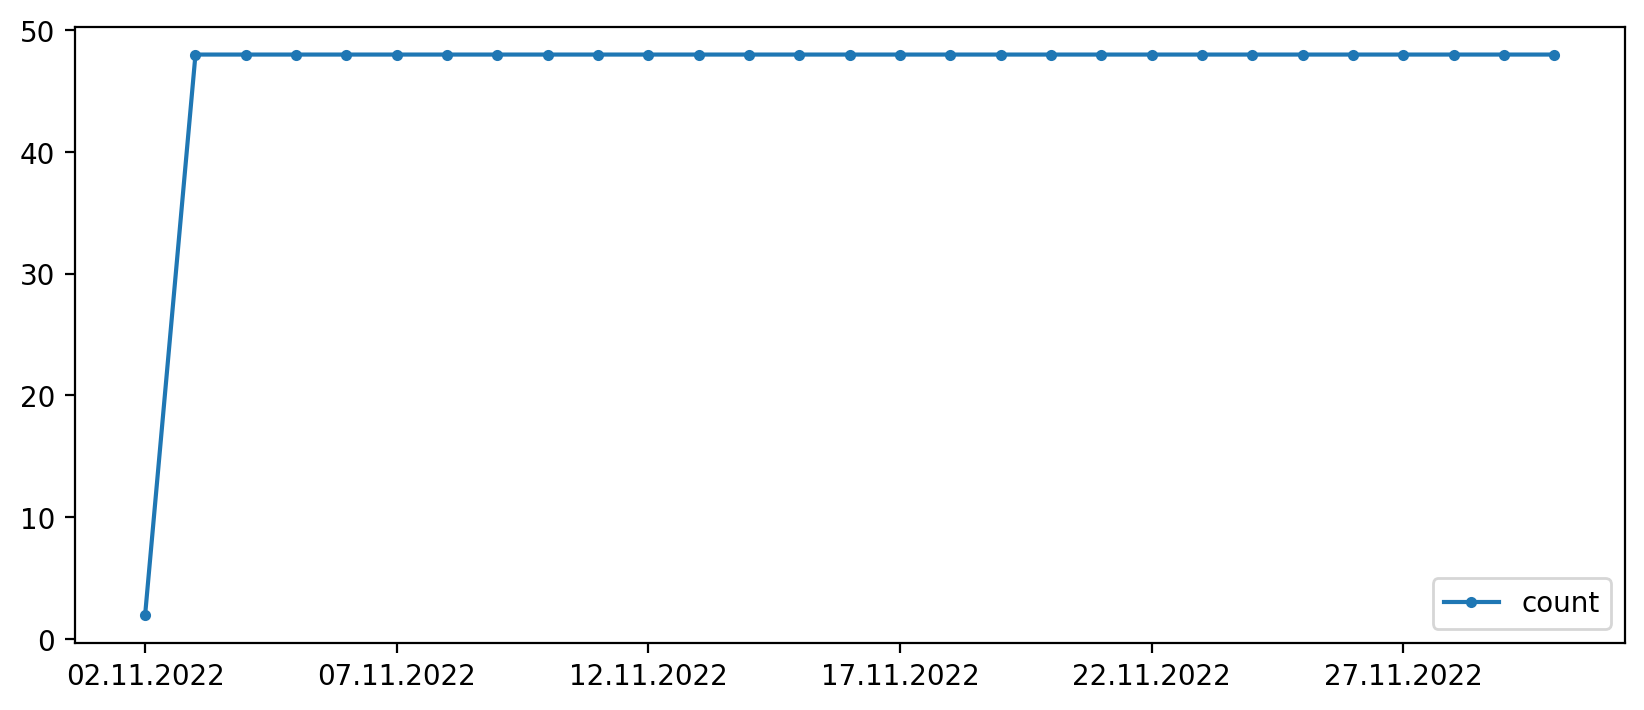

In [25]:
result = data_weather.aggregate([
    {"$group":  { "_id": { "$dateToString": { "format": "%d.%m.%Y", "date": {"$toDate": "$timestamp"} } }, "count": {"$sum": 1} } }, {"$sort": { "_id": 1 } } ])
plot = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", style='.-')

## 5.2 Evaluation – Wetter

Wetter in Mannheim:

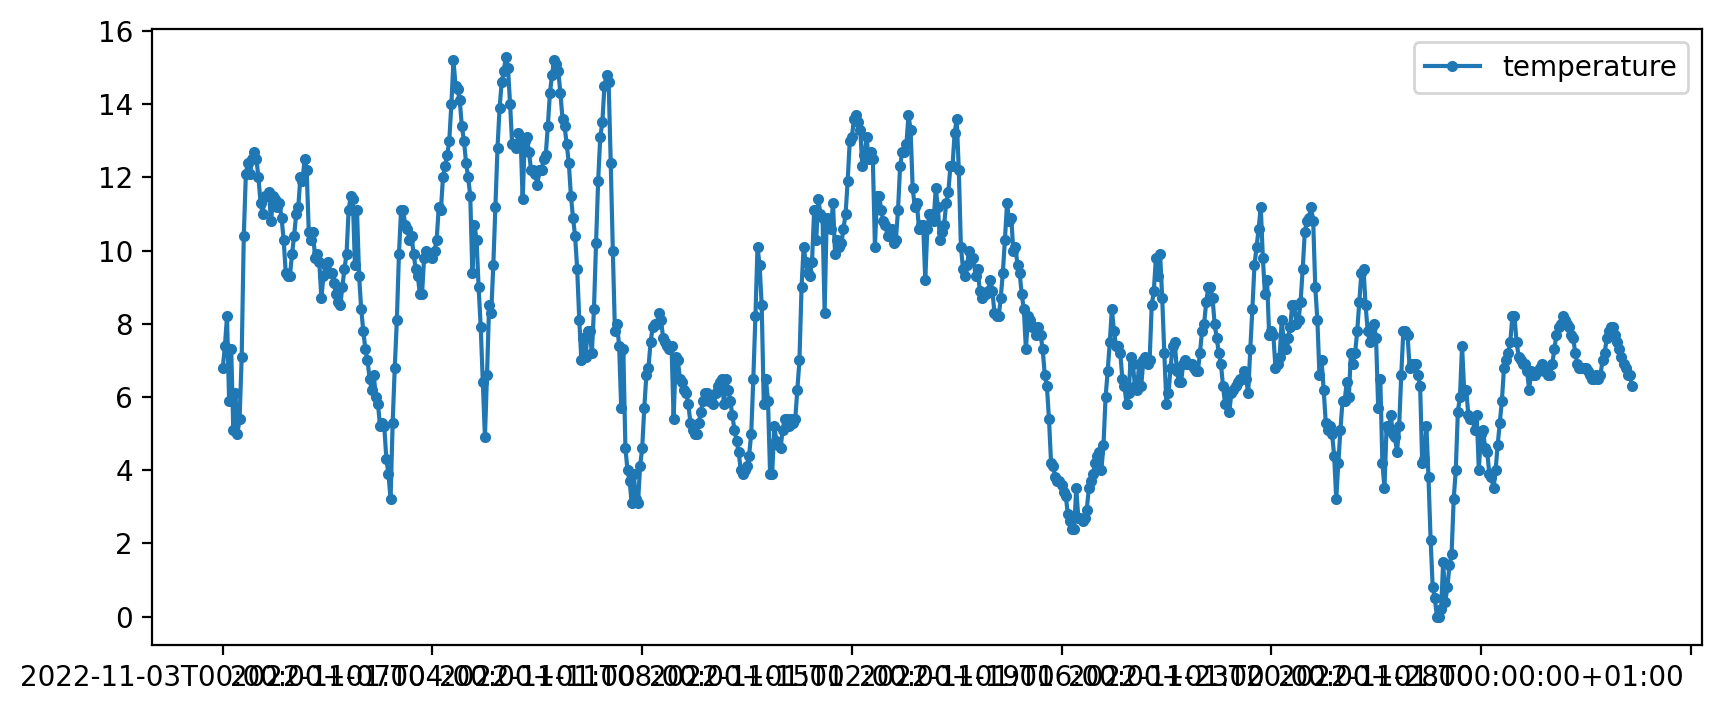

In [21]:
result = data_weather.find({ "lat": 49.5, "lon": 8.48 })
plot = DataFrame(result).plot(x="timestamp", y="temperature", kind="line", xlabel="", style='.-')

## 5.3 Evaluation – Züge Einführung

In [10]:
print(f"{data_train.count_documents(filter={}):,}")

260,704


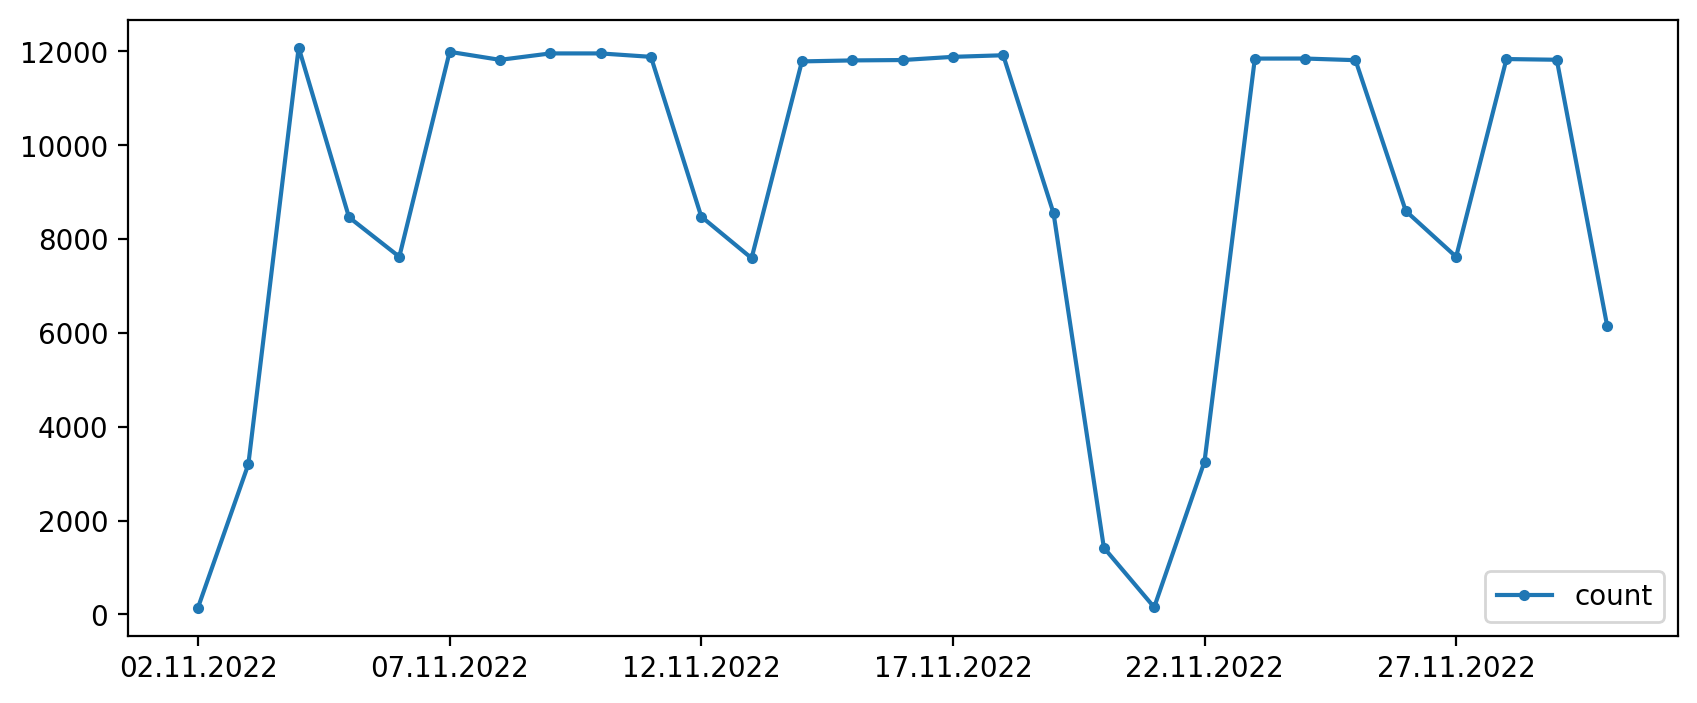

In [26]:
result = data_train.aggregate([
    {"$group": { "_id": { "$dateToString": { "format": "%d.%m.%Y", "date": {"$toDate": "$timestamp"} } }, "count": {"$sum": 1} } }, {"$sort": { "_id": 1 } } ])
plot = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", style='.-')

## 5.4 Evaluation – Zug-Arten

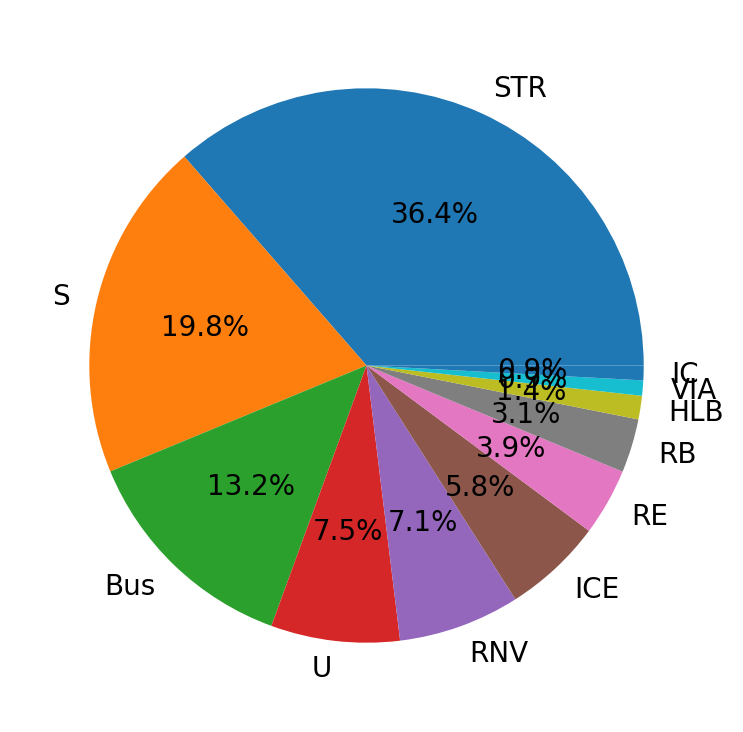

In [12]:
result = data_train.aggregate([
    {"$group": { "_id": "$con_type", "count": {"$sum": 1} } },
    {"$sort": { "count": -1 } },
    {"$limit": 11 } ])
df = DataFrame(result)
plot = df.plot(x="_id", y="count", kind="pie", labels=df['_id'], legend=False, figsize=(4.5,4.5), autopct='%1.1f%%', ylabel="")

## 5.5 Evaluation – Delay

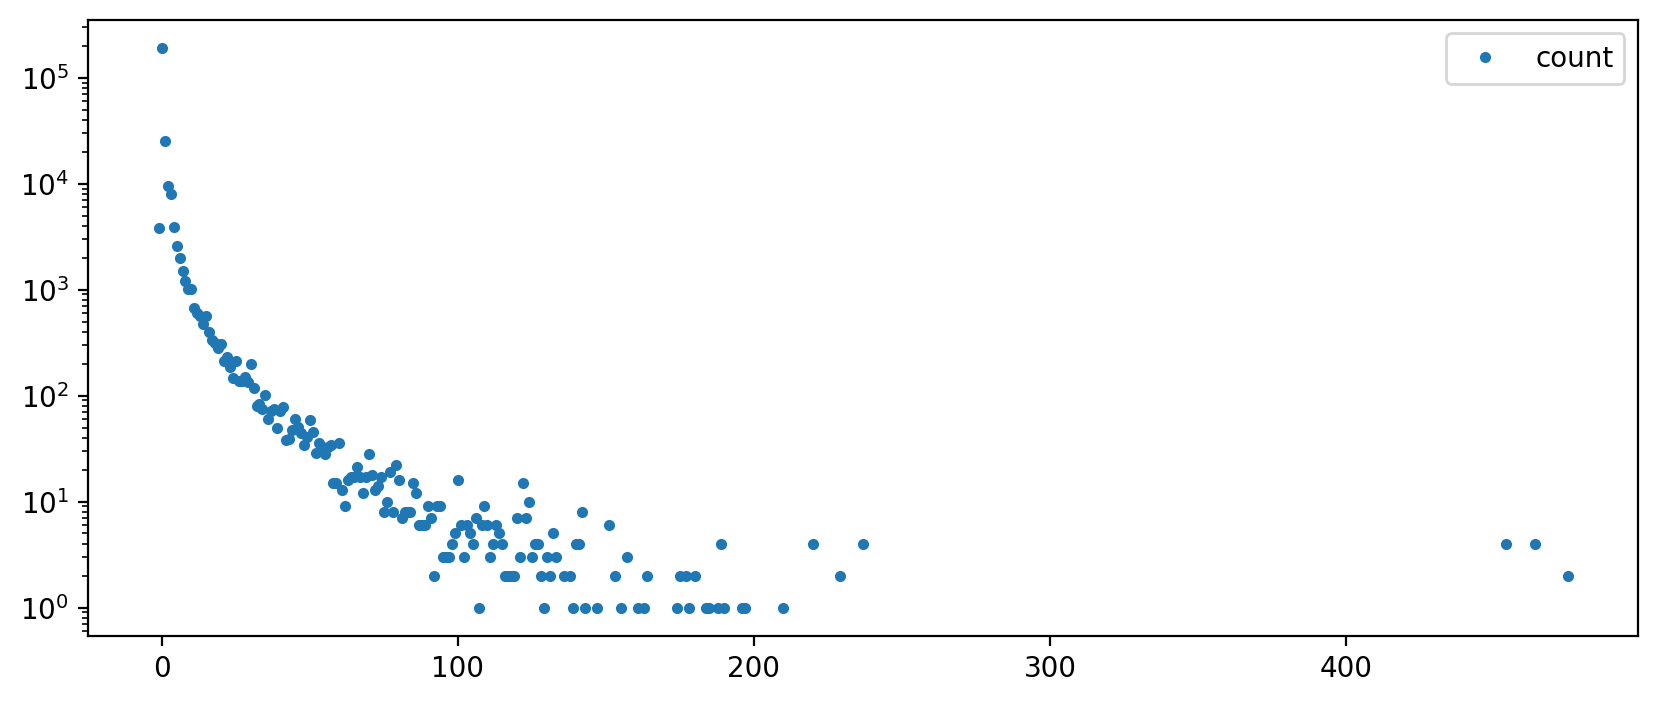

In [13]:
result = data_train.aggregate([
    {"$group": { "_id": "$delay", "count": {"$sum": 1} } },
    {"$sort": { "count": 1 } } ])
plot = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", style='.', logy=True)

## 5.6 Evaluation – Delay

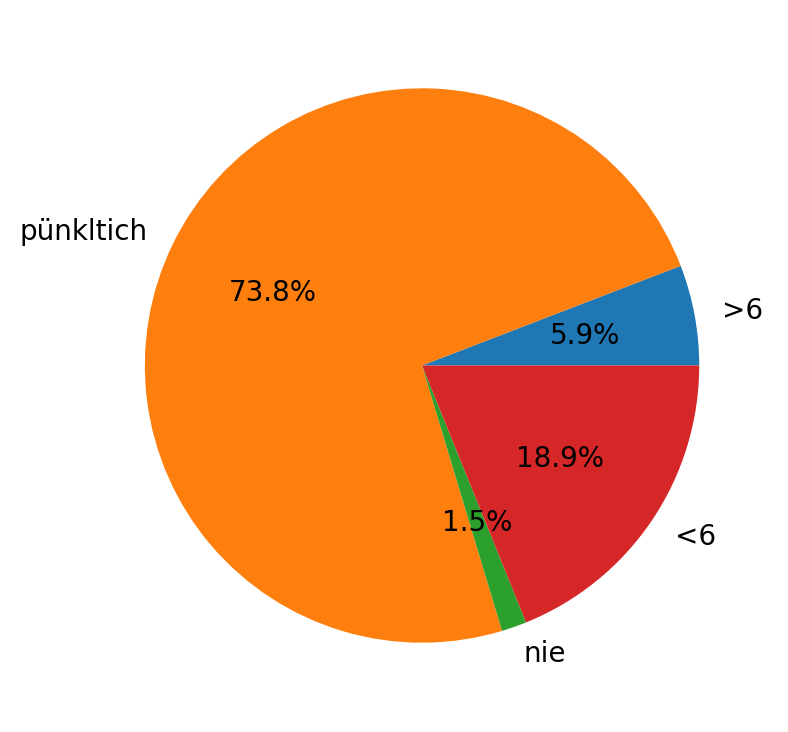

In [14]:
result = data_train.aggregate([
  {"$addFields": { "range": { "$switch": { "branches": [ { "case": { "$eq": [ "$delay", -1 ] }, "then": "nie" }, { "case": { "$eq": [ "$delay",  0 ] }, "then": "pünkltich"  }, { "case": { "$lte": [ "$delay", 5 ] }, "then": "<6" }],  "default": ">6" } } } },
  {"$group": { "_id": "$range", "count": { "$sum": 1 } } } ])
df = DataFrame(result)
plot = df.plot(x="_id", y="count", kind="pie", ylabel="", labels=df['_id'], legend=False, figsize=(4.5,4.5), autopct='%1.1f%%')

## 5.6 Evaluation – Delay ICE

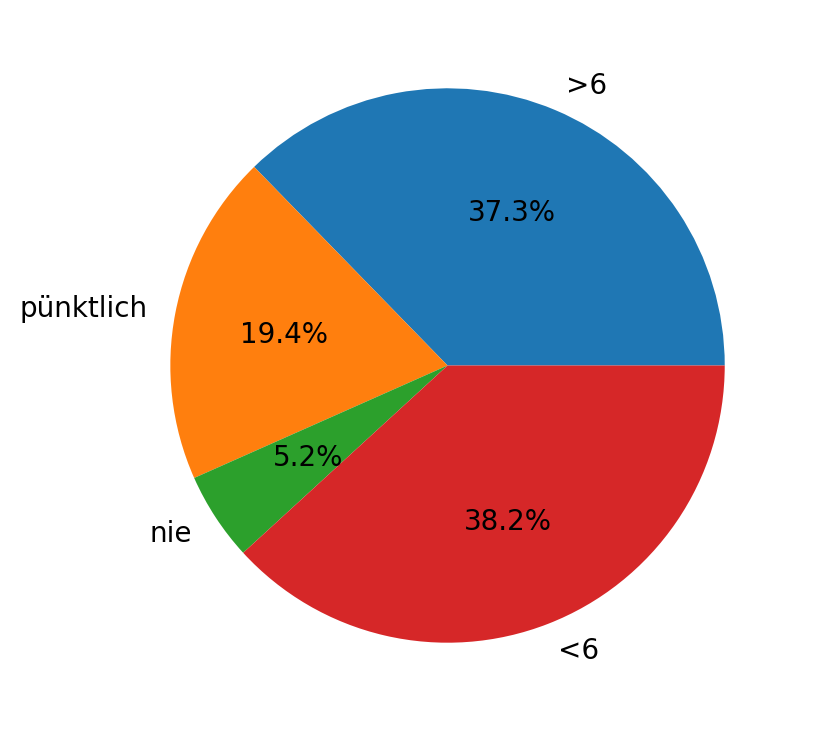

In [15]:
result = data_train.aggregate([
  {"$match": {"con_type": "ICE"} },
  {"$addFields": { "range": { "$switch": { "branches": [ { "case": { "$eq": [ "$delay", -1 ] }, "then": "nie" }, { "case": { "$eq": [ "$delay",  0 ] }, "then": "pünktlich"  }, { "case": { "$lte": [ "$delay", 5 ] }, "then": "<6" }],  "default": ">6" } } } },
  {"$group": { "_id": "$range", "count": { "$sum": 1 } } } ])
df = DataFrame(result)
plot = df.plot(x="_id", y="count", kind="pie", ylabel="", labels=df['_id'], legend=False, figsize=(4.5,4.5), autopct='%1.1f%%')

## 5.7 Evaluation – Walk of Shame

In [16]:
DataFrame(data_train.find(sort=[("delay", -1)], filter={"board_type": "arr"}).limit(3))

,_id,board_type,con_line,con_type,eva,timestamp,delay
0,63647221e60c50489303e036,arr,11,STR,8000105,2022-11-04T03:36:00+01:00,475
1,63648031e60c50489303e355,arr,11,STR,8000105,2022-11-04T04:40:00+01:00,464
2,63648031e60c50489303e34f,arr,11,STR,8000105,2022-11-04T04:39:00+01:00,464


... ohne Straßenbahnen ...

In [17]:
DataFrame(data_train.find(sort=[("delay", -1)], filter={"board_type": "arr","con_type": {"$ne": "STR"}}).limit(3))

,_id,board_type,con_line,con_type,eva,timestamp,delay
0,636e9bb2e60c50489308850a,arr,821,ICE,8000105,2022-11-11T20:48:00+01:00,210
1,6383f2fa20f4eac89dabea92,arr,879,ICE,8000244,2022-11-28T01:27:00+01:00,197
2,6383ebf220f4eac89dabe744,arr,879,ICE,8000105,2022-11-28T00:44:00+01:00,190


## 5.8 Evaluation – Züge + Temperatur

# TBD

* Wetter kombis temp <> verspätung (Zugart)

In [24]:
result = data_train.aggregate([
  {"$lookup": { "localField": 'site',
                'from': 'tableTWO',
                'foreignField': 'site',
                'as': 'site_yo'
        } },
  {"$group": { "_id": "$range", "count": { "$sum": 1 } } } ])
df = DataFrame(result)
df

,_id,count
0,None,260999


In [ ]:
        
            { '$unwind': '$site_yo' },
         {
            '$group': {
                '_id': {
                    'site': '$site',
                    'date': '$site_yo.date',
                },
                'starts': {
                    '$sum': '$starts'
                }
            }
        }, {
            '$project': {
                '_id': 0,
                'site': '$_id.site',
                'date': '$_id.date',
                'starts': '$starts',
                'finishes': '$starts'
            }
        }

## 6. Deployment  – Fazit

* **Eingangsfrage**: 
  * noch nicht genug Daten für zuverlässige Aussage
* **Sonstige Probleme/Herausforderungen**: 
  * Server ist im Betrieb eingefroren aus unbekannter Ursache
  * erst zwei Tage Später festgestellt, da Monitoring-Software nicht ausgelöst

Datenbank trennen:

In [19]:
database.close()